2024-04-23 01:19:14.857 Python[51778:2275525] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


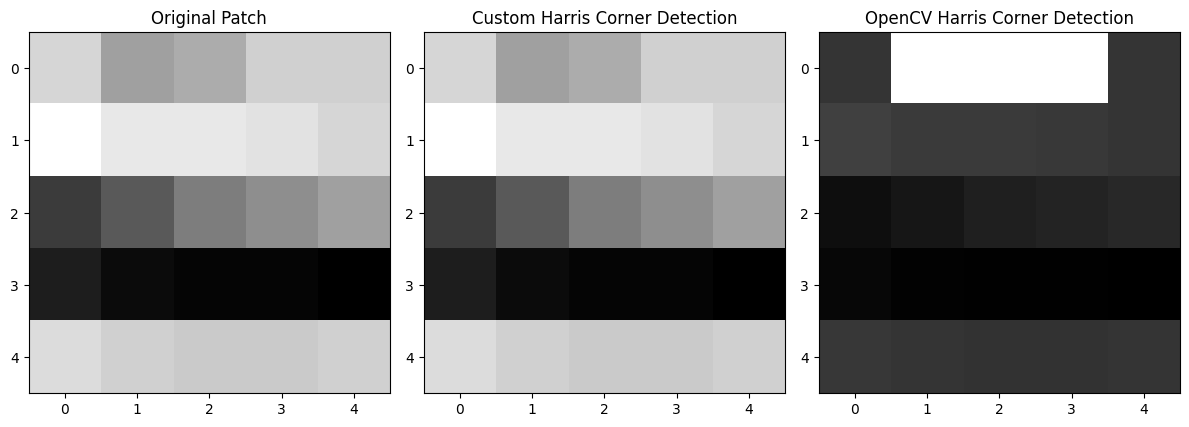

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Kernel operation using input operator of size 3*3
def GetSobel(image, Sobel, width, height):
    # Initialize the matrix
    I_d = np.zeros((width, height), np.float32)

    # For every pixel in the image
    for rows in range(width):
        for cols in range(height):
            # Run the Sobel kernel for each pixel
            if rows >= 1 or rows <= width-2 and cols >= 1 or cols <= height-2:
                for ind in range(3):
                    for ite in range(3):
                        I_d[rows][cols] += Sobel[ind][ite] * image[rows - ind - 1][cols - ite - 1]
            else:
                I_d[rows][cols] = image[rows][cols]

    return I_d


# Method implements the Harris Corner Detection algorithm
def HarrisCornerDetection(image):

    # The two Sobel operators - for x and y direction
    SobelX = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    SobelY = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    w, h = image.shape

    # X and Y derivative of image using Sobel operator
    ImgX = GetSobel(image, SobelX, w, h)
    ImgY = GetSobel(image, SobelY, w, h)

    for ind1 in range(w):
        for ind2 in range(h):
            if ImgY[ind1][ind2] < 0:
                ImgY[ind1][ind2] *= -1
            if ImgX[ind1][ind2] < 0:
                ImgX[ind1][ind2] *= -1

    ImgX_2 = np.square(ImgX)
    ImgY_2 = np.square(ImgY)

    ImgXY = np.multiply(ImgX, ImgY)
    ImgYX = np.multiply(ImgY, ImgX)

    # Use Gaussian Blur
    Sigma = 1.4
    kernelsize = (3, 3)

    ImgX_2 = cv2.GaussianBlur(ImgX_2, kernelsize, Sigma)
    ImgY_2 = cv2.GaussianBlur(ImgY_2, kernelsize, Sigma)
    ImgXY = cv2.GaussianBlur(ImgXY, kernelsize, Sigma)
    ImgYX = cv2.GaussianBlur(ImgYX, kernelsize, Sigma)

    alpha = 0.06
    R = np.zeros((w, h), np.float32)
    # For every pixel find the corner strength
    for row in range(w):
        for col in range(h):
            M_bar = np.array([[ImgX_2[row][col], ImgXY[row][col]], [ImgYX[row][col], ImgY_2[row][col]]])
            R[row][col] = np.linalg.det(M_bar) - (alpha * np.square(np.trace(M_bar)))
    return R


# Load the video
video_path = "static/SampleVideo.mp4"
cap = cv2.VideoCapture(video_path)

# Read the first frame from the video
ret, frame = cap.read()

# Convert frame to grayscale for OpenCV's Canny function
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Select ROI
roi = cv2.selectROI(gray_frame)
cv2.destroyAllWindows()

# Check if ROI selection is valid
if roi[2] == 0 or roi[3] == 0:
    print("Invalid ROI selection. Please try again.")
    exit()
    
# Extract a 5x5 patch from the selected ROI
patch_size = 5
x_top_left, y_top_left, width, height = roi
patch_x = x_top_left
patch_y = y_top_left
patch_width = min(width, patch_size)  # Clamp width to 5 if exceeding
patch_height = min(height, patch_size)  # Clamp height to 5 if exceeding

# Ensure patch doesn't exceed image boundaries
patch_width = min(patch_width, gray_frame.shape[1] - patch_x)  # Clamp width to available image width
patch_height = min(patch_height, gray_frame.shape[0] - patch_y)  # Clamp height to available image height

patch = gray_frame[patch_y:patch_y + patch_height, patch_x:patch_x + patch_width]

# Check if patch is empty
if patch.size == 0:
    print("Selected ROI does not contain any image data.")
    exit()

# Apply custom Harris corner detection
custom_corners = HarrisCornerDetection(patch)

# Apply OpenCV's Harris corner detection
opencv_corners = cv2.cornerHarris(patch, 3, 3, 0.04)

# Thresholding for visualization
custom_corners_thresh = 0.01 * custom_corners.max()
opencv_corners_thresh = 0.002 * opencv_corners.max()

# Create copies of the original patch for visualization
patch_custom = np.copy(patch)
patch_opencv = np.copy(patch)

# Mark custom corners
patch_custom[custom_corners > custom_corners_thresh] = 255

# Mark OpenCV corners
patch_opencv[opencv_corners > opencv_corners_thresh] = 255

# Display original patch and results
plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(patch, cmap="gray"), plt.title("Original Patch")
plt.subplot(132), plt.imshow(patch_custom, cmap="gray"), plt.title("Custom Harris Corner Detection")
plt.subplot(133), plt.imshow(patch_opencv, cmap="gray"), plt.title("OpenCV Harris Corner Detection")
plt.tight_layout()
plt.show()